# PS4: Gradient descent and regularization
This is a fun but challenging problem set. It will test your python skills, as well as your understanding of the material in class and in the readings. Start early and debug often! Some notes:

* Part 1 is meant to be easy, so get through it quickly.
* Part 2 (especially 2.1) will be difficult, but it is the lynchpin of this problem set so make sure to do it well and understand what you've done. If you find your gradient descent algorithm is taking more than a few minutes to complete, debug more, compare notes with others, and go to the TA sessions (especially the sections on vectorized computation and computational efficiency).
* Depending on how well you've done 2.1, parts 2.3 and 4.3 will be relatively painless or incredibly painful. 
* Part 4 (especially 4.3) will be computationally intensive. Don't leave this until the last minute, otherwise your code might be running when the deadline arrives.
* Do the extra credit problems last.

---

## Introduction to the assignment

As with the last assignment, you will be using a modified version of the [California Housing Prices Dataset](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html). Please download the csv file from bcourses ('cal_housing_data_clean_ps4.csv'). 

To perform any randomized operation, only use functions in the *numpy library (np.random)*. Do not use other packages for random functions.

In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn

%matplotlib inline  
import matplotlib.pyplot as plt  
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

from sklearn.linear_model import Ridge

In [2]:
# Load the California Housing Dataset 
cal_df = pd.read_csv('cal_housing_data_clean_ps4.csv')

# leave the following line untouched, it will help ensure that your "random" split is the same "random" split used by the rest of the class
np.random.seed(seed=1948)
print(cal_df.head(5))

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup     DistCoast  \
0  3.6885        49  5.184569   1.052950        2363  3.574887   4205.460788   
1  3.1630        26  4.267241   0.961207         719  3.099138  28060.624020   
2  2.8042        35  3.895018   1.080071        1193  2.122776  20913.168450   
3  4.2305        32  5.891775   1.235931        2541  5.500000  21878.282810   
4  4.7663        38  5.566038   1.015094         827  3.120755  16863.074990   

   Inland  MedHouseVal  
0       0        2.540  
1       0        1.794  
2       0        2.409  
3       0        2.214  
4       0        1.916  


---

# Part 1: Getting oriented


### 1.1 Use existing libraries

Soon, you will write your own gradient descent algorithm, which you will then use to minimize the squared error cost function.  First, however, let's use the canned versions that come with Python, to make sure we understand what we're aiming to achieve.

Use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to explore the relationship between median housing value and median income in California's census block groups. 

(a) Regress the median housing value `MedHouseVal` on the median income `MedInc`. Draw a scatter plot of housing price (y-axis) against income (x-axis), and draw the regression line in blue.  You might want to make the dots semi-transparent if it improves the presentation of the figure. 

(b) Regress the median housing value on median income and median income squared.  Plot this new (curved) regression line in gold, on the same axes used for part (a). 

(c) Interpret your results.

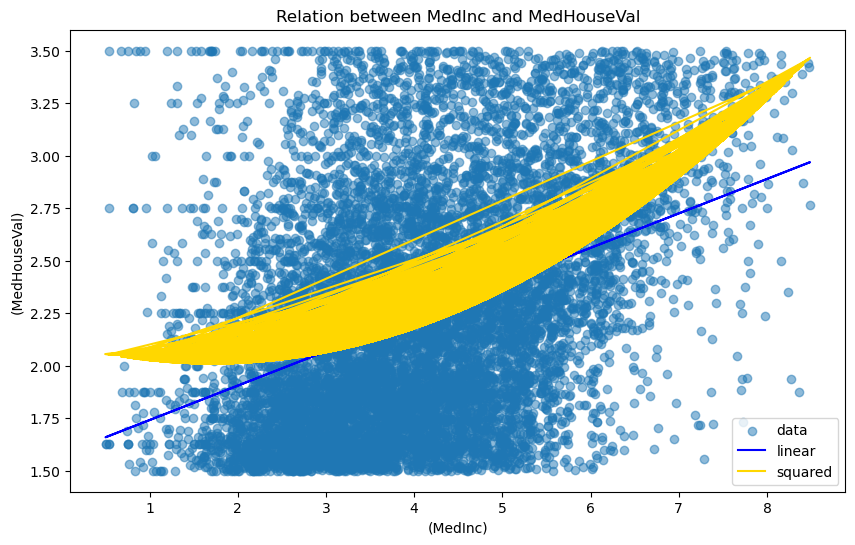

In [3]:
# Your code here

X = cal_df['MedInc'].values.reshape(-1,1)
y = cal_df['MedHouseVal'].values
## linear regression
linear_model = LinearRegression().fit(X,y)
y_pred_linear = linear_model.predict(X)

## squared regression
X_quad = np.hstack((X,X**2))
quad_model = LinearRegression().fit(X_quad,y)
y_pred_quad = quad_model.predict(X_quad)

## plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5, label='data')
plt.plot(X, y_pred_linear, color='blue', label='linear')
plt.plot(X, y_pred_quad, color='gold', label='squared')
plt.xlabel('(MedInc)')
plt.ylabel('(MedHouseVal)')
plt.title('Relation between MedInc and MedHouseVal')
plt.legend()
plt.show()


*Enter your observations here*  
* The linear regression line suggests a direct proportional relationship between median income and house value, while the quadratic line indicates that the rate of increase in house value becomes greater as median income rises. This could suggest that as income increases, house values do not just increase linearly but at an accelerating rate.

### 1.2 Training and testing

Chances are, for the above problem you used all of your data to fit the regression line. In some circumstances this is a reasonable thing to do, but if your primary objective is prediction, you should be careful about overfitting. Let's redo the above results the ML way, using careful cross-validation.  Since you are now experts in cross-validation, and have written your own cross-validation algorithm from scratch, you can now take a shortcut and use the libraries that others have built for you.

Using the [cross-validation functions](http://scikit-learn.org/stable/modules/cross_validation.html) from scikit-learn, use 5-fold cross-validation to fit the regression model (a) from 1.1, i.e. the linear fit of median housing value on median income. Each fold of cross-validation will give you one slope coefficient and one intercept coefficient.  Create a new scatterplot of housing price against income, and draw the five different regression lines in light blue, and the original regression line from 1.1 in red (which was estimated using the full dataset). What do you notice?

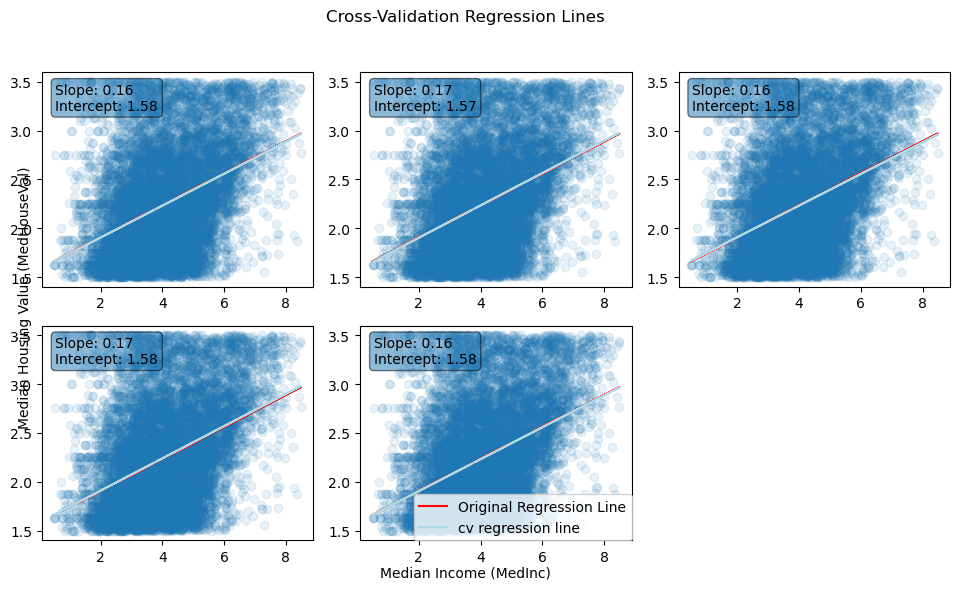

final slope is: 0.16400883709330877
final intercept is: 1.5772449852370265


In [39]:
from sklearn.model_selection import KFold

# your code here
## Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)

## store the coefficients
slopes = []
intercepts = []

## perform
for train_i, test_i in kf.split(X):
    X_train, X_test = X[train_i], X[test_i]
    y_train, y_test = y[train_i], y[test_i]
    
    # Fit the linear regression model on the training data
    model_cv = LinearRegression().fit(X_train, y_train)
    
    # Save the slope and intercept
    slopes.append(model_cv.coef_[0])
    intercepts.append(model_cv.intercept_)
plt.figure(figsize=(10, 6))

# when I found all my rmse wrong, I checked all the possible mistakes I could make
# but I didn't solve the problem. Suddenly, I found that at the beginning, the RMSE
# began to be wrong which is impossible to make mistakes here when using sklearn.
# So I changed the way to compute RMSE(as below). And everything turned to be great!
# That is because y_pred and y_test have different dimensions(2,and 1) So i USED .flatten()to make it appropriate.
# def compute_rmse(predictions, yvalues):
#     rmse = np.sqrt(np.mean((predictions - yvalues) ** 2))
#     return rmse

# Cross-validation regression lines 
i=1
for slope, intercept in zip(slopes, intercepts):
    y_pred_cv = slope * X + intercept
    plt.subplot(2,3,i)
    plt.scatter(X, y, alpha=0.1)
    # print("rmse is: ", compute_rmse(y_pred_cv, y))
    # Original regression line
    plt.plot(X, y_pred_linear, color='red', label='Original Regression Line')
    plt.plot(X, y_pred_cv, color='lightblue', alpha=1, label = 'cv regression line')
    plt.annotate(f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', 
                    verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))
    # if i==1:
    #     plt.legend()
    i+=1

plt.figtext(0.5, 0.04, 'Median Income (MedInc)', ha='center', va='center')
plt.figtext(0.06, 0.5, 'Median Housing Value (MedHouseVal)', ha='center', va='center', rotation='vertical')

plt.suptitle('Cross-Validation Regression Lines')  
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])  

plt.legend(loc='lower right', borderaxespad=0)

plt.show()

print("final slope is:",np.mean(slopes))
print("final intercept is:",np.mean(intercepts))

*Enter your observations here*  
* There aren't many differences among the 5 folds. So, it seems that there aren't any overfitting in the trainning. The average intercept is 1.5772 and the average slope is 0.164.

# Part 2: Gradient descent: Linear Regression

This is where it gets fun!

### 2.1 Implement gradient descent with one independent variable (median income)

Implement the batch gradient descent algorithm that we discussed in class. Use the version you implement to regress the median house value on the median income. Experiment with 3-4 different values of the learning rate *R*, and do the following:

* Report the values of alpha and beta that minimize the loss function
* Report the number of iterations it takes for your algorithm to converge (for each value of *R*)
* Report the total running time of your algorithm, in seconds
* How do your coefficients compare to the ones estimated through standard libraries in 1.1? Does this depend on *R*?

Some skeleton code is provided below, but you should feel free to delete this code and start from scratch if you prefer.

* *Hint 1: Don't forget to implement a stopping condition, so that at every iteration you check whether your results have converged. Common approaches to this are to (a) check to see if the loss has stopped decreasing; and (b) check if both your current parameter esimates are close to the estimates from the previous iteration.  In both cases, "close" should not be ==0, it should be <=epsilon, where epsilon is something very small (like 0.0001).*
* *Hint 2: We recommend including a MaxIterations parameter in their gradient descent algorithm, to make sure things don't go off the rails, i.e., as a safeguard in case your algorithm isn't converging as it should. *

Time taken: 1.40 seconds
Time taken: 1.33 seconds
Time taken: 1.36 seconds
iteration : 779
Time taken: 1.07 seconds
      Alpha      Beta
0  0.238564  0.462117
1  0.993451  0.294013
2  1.562780  0.167231
3  1.576180  0.164247


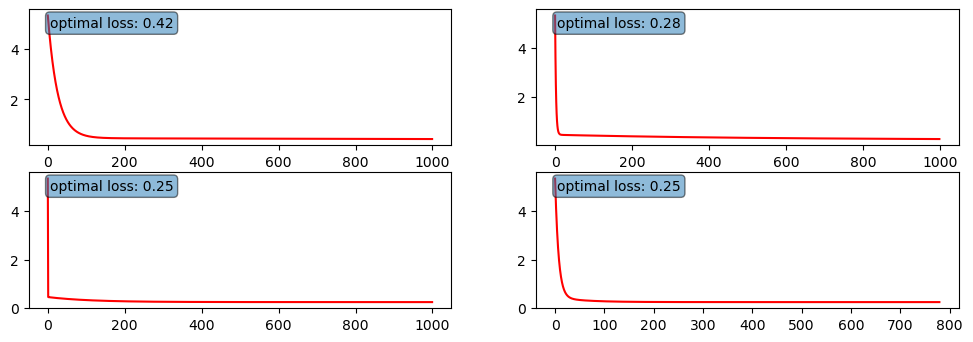

In [40]:
import time

"""
Function
--------
bivariate_ols
    Gradient Decent to minimize OLS. Used to find coefficients of bivariate OLS Linear regression

Parameters
----------
xvalues, yvalues : narray
    xvalues: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta: float
    coefficient
"""
def bivariate_ols(xvalues, yvalues, R=0.01, MaxIterations=1000, i=1):
    start_time = time.time()
    #your code here
    # initialization
    epsilon = 0.00001
    alpha, beta = 0, 0
    n = len(xvalues)
    it = []
    loss =[]
    losss=0
    # define loss function:
    ## J = 1\2N *SUM(y_pred-y)**2
    # gradient descenting
    for iteration in range(MaxIterations):
        #calculate predicted y
        y_pred = alpha + beta * xvalues
        # delta = yvalues-y_pred
        # losss = np.mean(delta**2)
        losss = np.mean((y_pred-yvalues)**2)
        loss.append(losss)
        it.append(iteration)
        #delta_alpha and delta_beta
        alpha_g = (1/n)* sum(y_pred-yvalues)
        beta_g = (1/n)* sum((y_pred-yvalues)*xvalues)
        # alpha_g = np.mean(delta)
        # beta_g = np.mean(delta*xvalues)
        #update
        new_alpha = alpha - R*alpha_g
        new_beta = beta - R*beta_g
        
        #check for convergence
        if abs(alpha-new_alpha) < epsilon and abs(beta-new_beta) < epsilon:
            print("iteration :",iteration)
            break
        alpha, beta = new_alpha, new_beta     

    #subplotting the loss
    plt.subplot(3,2,i)
    plt.plot(it, loss, color='red', label='loss')
    plt.annotate(f'optimal loss: {losss:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', 
                    verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    return alpha, beta

#perform gradient descending
xvalues = cal_df['MedInc'].values
yvalues = cal_df['MedHouseVal'].values

learning_rate = [0.001, 0.01, 0.05,0.1]
results = []
plt.figure(figsize=(12,6))
i=1
for R in learning_rate:
    alpha, beta = bivariate_ols(xvalues, yvalues, R=R,i=i)
    i+=1
    results.append({'Alpha': alpha, 'Beta': beta})

final_results = pd.DataFrame(results)
print(final_results)

*Enter your observations here*  
* Report the values of alpha and beta that minimize the loss function:$~\alpha = 1.562780, \beta = 0.167231$
* 
Report the number of iterations it takes for your algorithm to converge (for each value of R: $~~\# of iteration= 779$ (the last one, the others are all 1000)
* 
Report the total running time of your algorithm, in secon: $t = 1.06s
* 
How do your coefficients compare to the ones estimated through standard libraries in 1.1? Does this depend  R?
*   The outcome intercepts are different depending on R. The learning rate determines the size of the steps taken towards the minimum of the loss function. If R is too large, the algorithm might overshoot the minimum; if it's too small, convergence might be slow or stall before reaching the minimuR?

### 2.2 Data normalization (done for you!)

Soon, you will implement a version of gradient descent that can use an arbitrary number of independent variables. Before doing this, we want to give you some code to standardize your features. 

**For all the following questions, unless explicitly asked otherwise, you are expected to standardize appropriately. Recall that in settings where you are using holdout data for validation or testing purposes, this involves substracting the average and dividing by the standard deviation of your training data.**

In [41]:
'''
Function
--------
standardize
    Column-wise standardization of a target dataframe using the mean and std of a reference dataframe

Parameters
----------
ref,tar : pd.DataFrame
    ref: reference dataframe
    tar: target dataframe
    
Returns
-------
tar_norm: pd.DataFrame
    Standardized target dataframe
'''
def standardize(ref,tar):
    tar_norm = ((tar - np.mean(ref, axis = 0)) / np.std(ref, axis = 0))
    return tar_norm

# Examples
##Standardize train: standardize(ref=x_train,tar=x_train)
# Standardize test: standardize(ref=x_train,tar=x_test)

### 2.3 Implement gradient descent with an arbitrary number of independent variables

Now that you have a simple version of gradient descent working, create a version of gradient descent that can take more than one independent variable.  Assume all independent variables will be continuous.  Test your algorithm using `MedInc`, `HouseAge` and `AveRooms` as independent variables. Remember to standardize appropriately before inputting them to the gradient descent algorithm. How do your coefficients compare to the ones estimated through standard libraries?

As before,  report and interpret your estimated coefficients, the number of iterations before convergence, and the total running time of your algorithm. Experiment with three values of R (0.1, 0.01, and 0.001).

* *Hint 1: Be careful to implement this efficiently, otherwise it might take a long time for your code to run. Commands like `np.dot` can be a good friend to you on this problem*

Time taken: 0.03 seconds
Time taken: 0.19 seconds
Time taken: 0.08 seconds
                      Alpha  \
0   [5.246047354207421e-16]   
1   [5.261194845760496e-16]   
2  [3.9259654919111163e-16]   

                                                                    Beta  
0  [[0.4662042514663159], [0.15885286524249162], [-0.05655627829215633]]  
1  [[0.4661787404710275], [0.15884415311158126], [-0.05653604060400563]]  
2  [[0.31726646105818274], [0.0832087175767394], [0.010690104853982418]]  


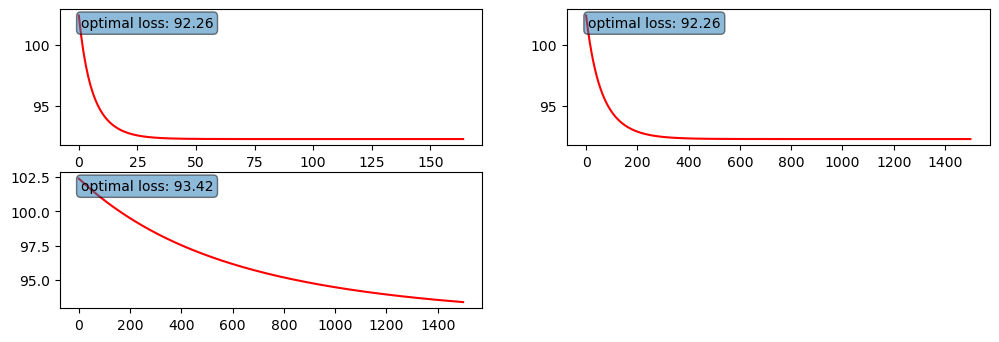

In [134]:
"""
Function
--------
multivariate_ols
    Gradient Decent to minimize OLS. Used to find coefficients of bivariate OLS Linear regression

Parameters
----------
xvalue_matrix, yvalues : narray
    xvalue_matrix: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta_array: array[float]
    coefficient
"""

def multivariate_ols(xvalue_matrix, yvalues, R=0.01, MaxIterations=1500,i=1):
    start_time = time.time()
    # your code here
    # initialization
    epsilon = 0.00001
    n, k = xvalue_matrix.shape  #k is the num of features
    X = np.hstack((np.ones((n,1)),xvalue_matrix ))
    y = yvalues.reshape(-1,1)
    beta = np.zeros((k+1,1))
    it = []
    loss =[]
    losss=0
    # define loss function:
    ## J = 1\2N *SUM(y_pred-y)**2
    # gradient descenting
    for iteration in range(MaxIterations):
        #calculate predictions
        predictions = np.dot(X,beta)
        
        delta = y - predictions
        gradient = -np.dot(X.T, delta)/n
        losss = np.linalg.norm(delta)
        loss.append(losss)
        it.append(iteration)
        if np.isnan(R):
            print("aaaa")
        # elif np.isnan(gradient):
        #     print("bbbb")
        #update
        beta = beta - R*gradient
        #check for convergence
        if np.linalg.norm(gradient) < epsilon:
            break
    # print("gradient:",gradient)
    #subplotting the loss
    plt.subplot(3,2,i)
    plt.plot(it, loss, color='red', label='loss')
    plt.annotate(f'optimal loss: {losss:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', 
                    verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    #outcome
    alpha = beta[0]
    beta_array = beta[1:]
    return alpha, beta_array

learning_rate = [0.1, 0.01, 0.001]
#perform gradient descending
features = cal_df[['MedInc','HouseAge', 'AveRooms']].values
target = cal_df['MedHouseVal'].values
#standize
features = standardize(ref=features,tar=features)
target = standardize(ref=target, tar=target)

results = []
plt.figure(figsize=(12,6))
i=1
for R in learning_rate:
    alpha, beta = multivariate_ols(features, target, R=R,i=i)
    i+=1
    results.append({'Alpha': alpha, 'Beta': beta})

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
final_results = pd.DataFrame(results)
print(final_results)
# print(final_results.iloc[1])

*Enter your observations here*  
* As before, report and interpret your estimated coefficients, the number of iterations before convergence, and the total running time of your algorithm. Experiment with three values of R (0.1, 0.01, and 0.001).
* $\alpha = 5.261194845760496e-16$ and $\beta =[0.4661787404710275], [0.15884415311158126], [-0.05653604060400563] $, $ \# $of iterations before convergence: $1500$ , total running time: $0.08s$
* with the decreasing of learning rate, the decreasing rate of the loss is getting smaller, which means the loss decreases slower and it takes more time for the algorithm to reach convergence.

### 2.4 Compare standardized vs. non-standardized results

Repeat the analysis from 2.3, but this time do not standardize your variables - i.e., use the original data. Use the same three values of R (0.1, 0.01, and 0.001). What do you notice about the running time and convergence properties of your algorithm? Compare to the results you would obtain using standard libraries. 

C:\Users\Skylar_xty\AppData\Local\Temp\ipykernel_31680\225782673.py:58: RuntimeWarning: invalid value encountered in subtract
  beta = beta - R*gradient


Time taken: 0.09 seconds
Time taken: 0.08 seconds
Time taken: 0.08 seconds
                   Alpha  \
0                  [nan]   
1                  [nan]   
2  [0.11642706789322743]   

                                                                     Beta  
0                                                   [[nan], [nan], [nan]]  
1                                                   [[nan], [nan], [nan]]  
2  [[0.3106756540873563], [0.022117091661671147], [0.033825202882381805]]  


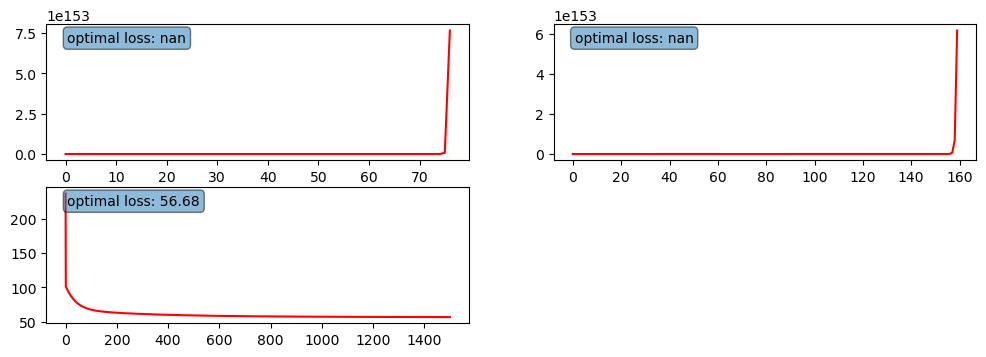

In [135]:
# Your code here
learning_rate = [0.1, 0.01, 0.001]
#perform gradient descending
features_withoutst = cal_df[['MedInc','HouseAge', 'AveRooms']].values
target_withoutst = cal_df['MedHouseVal'].values

results = []
plt.figure(figsize=(12,6))

i=1
for R in learning_rate:
    alpha, beta = multivariate_ols(features_withoutst, target_withoutst, R=R,i=i)
    i+=1
    results.append({'Alpha': alpha, 'Beta': beta})

final_results = pd.DataFrame(results)
print(final_results)

*Enter your observations here*  
* I found that if we didn't use the standardization before training, the gradient descending algorithm would probably diverge, which would lead to NaN in the outcome. 

# 3. Prediction

Let's use our fitted model to make predictions about housing prices. 

### 3.1 Cross-Validation

Unless you were careful above, you probably overfit your data again. Let's fix that. Use 5-fold cross-validation to re-fit the multivariate regression from 2.3 above, and report your estimated coefficients (there should be four, corresponding to the intercept and the three coefficients for `MedInc` and `AveRoomsNorm`, `HouseAgeNorm`). Since there are 5 folds, there will be 5 sets of four coefficients -- report them all in a 5x4 table.

**Note:** You can use KFold to perform the cross-validation. 

Time taken: 0.10 seconds
[0.0010532]
[[ 0.0010532 ]
 [ 0.46542345]
 [ 0.16454588]
 [-0.04675087]]
Time taken: 0.09 seconds
[0.00076972]
[[ 0.00076972]
 [ 0.46842457]
 [ 0.15464627]
 [-0.06898143]]
Time taken: 0.09 seconds
[0.00075386]
[[ 0.00075386]
 [ 0.46649103]
 [ 0.15809493]
 [-0.05827428]]
Time taken: 0.09 seconds
[-0.00250661]
[[-0.00250661]
 [ 0.4676356 ]
 [ 0.15889605]
 [-0.0600266 ]]
Time taken: 0.09 seconds
[-0.00015323]
[[-1.53234742e-04]
 [ 4.64755168e-01]
 [ 1.57602186e-01]
 [-5.40654571e-02]]
   Intercept  Beta_MedInc  Beta_AveRooms  Beta_HouseAge
0   0.001053     0.465423       0.164546      -0.046751
1   0.000770     0.468425       0.154646      -0.068981
2   0.000754     0.466491       0.158095      -0.058274
3  -0.002507     0.467636       0.158896      -0.060027
4  -0.000153     0.464755       0.157602      -0.054065


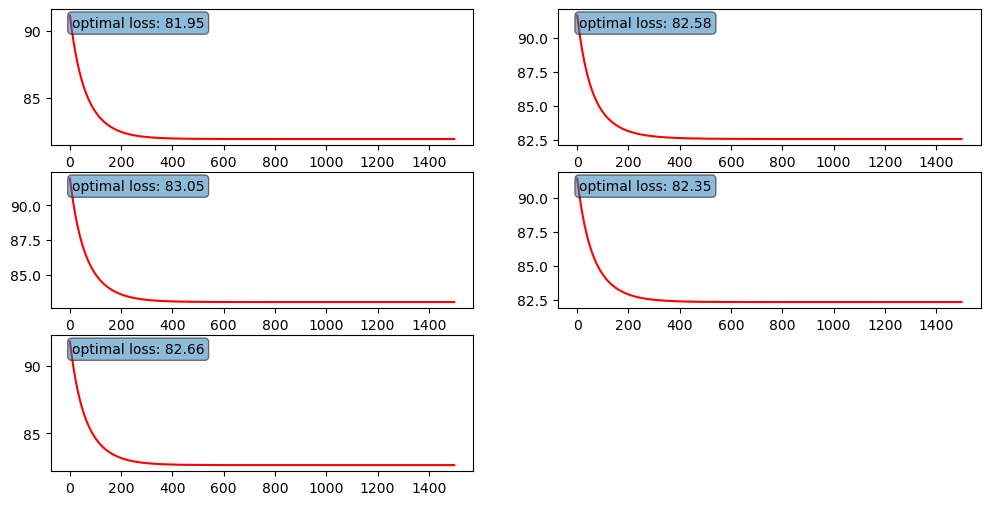

In [136]:
# def compute_rmse(predictions, yvalues):
#     P = np.array(predictions)
#     Y = np.array(yvalues)
#     rmse = ((P-Y)**2).sum()*1.0 / len(P) 
#     rmse = np.sqrt(rmse)
#     return rmse
def compute_rmse(predictions, yvalues):
    rmse = np.sqrt(np.mean((predictions - yvalues) ** 2))
    return rmse

# Your code here
kf = KFold(n_splits = 5, shuffle=True, random_state=42)
plt.figure(figsize=(12,6))
coeffs = []

#use the standardized data above: features, target
## perform
i=1
for train_i, test_i in kf.split(features):
    X_train, X_test = features[train_i], features[test_i]
    y_train, y_test = target[train_i], target[test_i]
    
    # add intercept term
    intercept = np.ones((X_train.shape[0],1))
    X_train_i = np.hstack([intercept, X_train])

    # model fitting
    alpha, beta = multivariate_ols(X_train_i, y_train, R=0.01,i=i)
    # save the coeffs
    # print(temp)
    coeffs.append(beta.flatten())
    print(alpha)
    print(beta)
    # coeffs.append(temp)
    i+=1

# print(coeffs)
coeffs_df = pd.DataFrame(coeffs, columns=['Intercept', 'Beta_MedInc', 'Beta_AveRooms', 'Beta_HouseAge'])
print(coeffs_df)

*Discuss your results here*  
* Each subplot likely represents the loss as the model trains over each fold of cross-validation. And it shows that the outcome is stable. The minimum loss and coefficients are similar. 

### 3.2 Predicted values and RMSE

Let's figure out how accurate this predictive model turned out to be. Compute the cross-validated RMSE for each of the 5 folds above. In other words, in fold 1, use the parameters estimated on the 80% of the data to make predictions for the 20%, and calculate the RMSE for those 20%. Repeate this for the remaining folds. Report the RMSE for each of the 5-folds, and the average (mean) RMSE across the five folds. How does this average RMSE compare to the performance of your nearest neighbor algorithm from the last problem set?

Time taken: 0.09 seconds
[0.0010532] [[ 0.0010532 ]
 [ 0.46542345]
 [ 0.16454588]
 [-0.04675087]]
Time taken: 0.08 seconds
[0.00076972] [[ 0.00076972]
 [ 0.46842457]
 [ 0.15464627]
 [-0.06898143]]
Time taken: 0.09 seconds
[0.00075386] [[ 0.00075386]
 [ 0.46649103]
 [ 0.15809493]
 [-0.05827428]]
Time taken: 0.09 seconds
[-0.00250661] [[-0.00250661]
 [ 0.4676356 ]
 [ 0.15889605]
 [-0.0600266 ]]
Time taken: 0.09 seconds
[-0.00015323] [[-1.53234742e-04]
 [ 4.64755168e-01]
 [ 1.57602186e-01]
 [-5.40654571e-02]]
   Intercept  Beta_MedInc  Beta_AveRooms  Beta_HouseAge
0   0.001053     0.465423       0.164546      -0.046751
1   0.000770     0.468425       0.154646      -0.068981
2   0.000754     0.466491       0.158095      -0.058274
3  -0.002507     0.467636       0.158896      -0.060027
4  -0.000153     0.464755       0.157602      -0.054065
RMSE SCORES: [0.9258236466422103, 0.8987939080512702, 0.8777762262388299, 0.9084406537487235, 0.8952618780961784]
avg RMSE: 0.9012192625554425


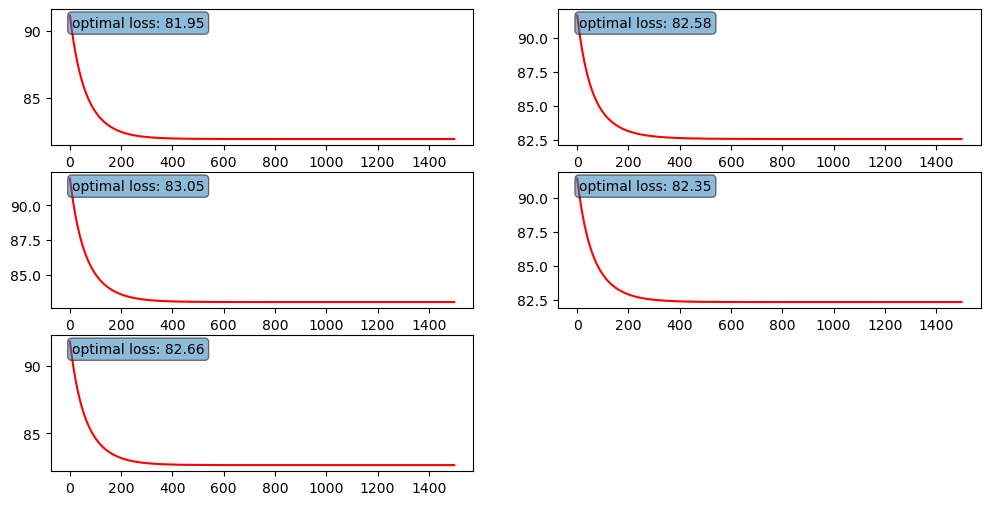

In [138]:
# Your code here
def compute_rmse(predictions, yvalues):
    P = np.array(predictions)
    Y = np.array(yvalues)
    rmse = ((P-Y)**2).sum()*1.0 / len(P) 
    rmse = np.sqrt(rmse)
    return rmse


kf = KFold(n_splits = 5, shuffle=True, random_state=42)
plt.figure(figsize=(12,6))
coeffs = []
rmse_scores =[]
#use the standardized data above: features, target
## perform
i=1
for train_i, test_i in kf.split(features):
    X_train, X_test = features[train_i], features[test_i]
    y_train, y_test = target[train_i], target[test_i]
    
    # add intercept term
    intercept = np.ones((X_train.shape[0],1))
    intercept2= np.ones((X_test.shape[0],1))
    X_train_i = np.hstack([intercept, X_train])
    X_test_i = np.hstack([intercept2, X_test])
    # model fitting
    alpha,beta = multivariate_ols(X_train_i, y_train, R=0.01,i=i)
    print(beta)
    # prediction
    y_pred = X_test_i @beta  #matrix Multiplication
    # calculate and store the rmse
    y_pred = y_pred.ravel()
    rmse = compute_rmse(y_test,y_pred)
    # print("y_test, y_pred:",y_test,y_pred)
    rmse_scores.append(rmse)
    # save the coeffs
    coeffs.append(beta.flatten())

    # coeffs.append(temp)
    i+=1

# print(coeffs)
coeffs_df = pd.DataFrame(coeffs, columns=['Intercept', 'Beta_MedInc', 'Beta_AveRooms', 'Beta_HouseAge'])
print(coeffs_df)
print("RMSE SCORES:",rmse_scores)
print("avg RMSE:", np.mean(rmse_scores))

*Discuss your results here*  
* the $RMSE$ for each fold:$ RMSE SCORES:  [0.9258122657127865, 0.8987876470785451, 0.8777700761539927, 0.908374952351819, 0.8952616288010626]$ and the average $RMSE$ is $0.9012013140196412$
* Compared to the $RMSE$ using the Nearest Neighbour algorithm(which is $ 1.030576100773797$), it is much lower.

## 4 Regularization 

### 4.1 Get prepped

Step 1: Generate features consisting of all polynomial combinations of degree greater than 0 and less than or equal to 3 of the following features: `MedInc`, `HouseAge` and `AveRooms`. If you are using PolynomialFeatures of sklearn.preprocessing make sure you drop the constant polynomial feature (degree 0). You should have a total of 19 polynomial features. 

Step 2: Randomly sample 80% of your data and call this the training set, and set aside the remaining 20% as your test set.

In [127]:
from sklearn.preprocessing import PolynomialFeatures
# Your code here
from sklearn.model_selection import train_test_split
# step1: generate polynomial features
features = cal_df[['MedInc','HouseAge', 'AveRooms']].values
poly = PolynomialFeatures(degree=3,include_bias=False)
poly_features = poly.fit_transform(features)

# step2: split the data into an 80%traing set
X_train, X_test, y_train, y_test = train_test_split(poly_features, cal_df['MedHouseVal'], test_size=0.2, random_state=42)

y_train = y_train.values
y_test = y_test.values
print(X_train.shape[1])
# print(X_train)
# print(X_train[:5])

19
[[6.88060000e+00 1.60000000e+01 8.27363184e+00 4.73426564e+01
  1.10089600e+02 5.69275512e+01 2.56000000e+02 1.32378109e+02
  6.84529838e+01 3.25745881e+02 7.57482502e+02 3.91695709e+02
  1.76143360e+03 9.10840820e+02 4.70997601e+02 4.09600000e+03
  2.11804975e+03 1.09524774e+03 5.66354787e+02]
 [3.20310000e+00 2.10000000e+01 4.61030596e+00 1.02598496e+01
  6.72651000e+01 1.47672710e+01 4.41000000e+02 9.68164251e+01
  2.12549210e+01 3.28633243e+01 2.15456842e+02 4.73010458e+01
  1.41256710e+03 3.10112691e+02 6.80816375e+01 9.26100000e+03
  2.03314493e+03 4.46353342e+02 9.79916891e+01]
 [3.27920000e+00 3.20000000e+01 4.65789474e+00 1.07531526e+01
  1.04934400e+02 1.52741684e+01 1.02400000e+03 1.49052632e+02
  2.16959834e+01 3.52617381e+01 3.44100884e+02 5.00870531e+01
  3.35790080e+03 4.88773389e+02 7.11454687e+01 3.27680000e+04
  4.76968421e+03 6.94271468e+02 1.01057607e+02]
 [4.22920000e+00 3.60000000e+01 5.76678445e+00 1.78861326e+01
  1.52251200e+02 2.43888848e+01 1.29600000e+03 

### 4.2 Complexity and overfitting?

Now, using your version of multivariate regression from 2.3, let's try to build a more complex model. **Remember to standardize appropriately!** Using the training set, regress the median house value on the polynomial features using your multivariate ols algorithm. Calculate train and test RMSE. Is this the result that you were expecting? How do these numbers compare to each other, and to the RMSE from 3.2 and nearest neighbors?

Time taken: 0.20 seconds
train_rmse: 0.4809541148160227
test_rmse: 0.49463557209988634


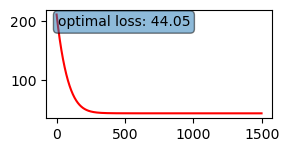

In [128]:
# Your code here
# standardization
X_train_st = standardize(X_train,X_train)
X_test_st = standardize(X_test,X_test)

# fit the model
alpha,beta = multivariate_ols(X_train_st, y_train, R=0.01)
# print(alpha,beta)
# coeffs = []
# coeffs.append(alpha)
# coeffs.append(beta)
# print(coeffs)

# predictions
y_train_pred = np.dot(X_train_st,beta)+alpha
y_test_pred = np.dot(X_test_st,beta)+alpha
y_train_pred = y_train_pred.flatten()
y_test_pred = y_test_pred.flatten()
# calculate rmse
train_rmse = compute_rmse(y_train_pred,y_train)
test_rmse = compute_rmse(y_test_pred,y_test)
print("train_rmse:",train_rmse)
print("test_rmse:",test_rmse)

*Discuss your results here*  
* No,it's not what I expected. Because the rmse is $0.49463557$ much smaller than the one in Q3.2 and the nearest neighbour algorithm. haha?

### 4.3 Ridge regularization (basic)
Incorporate L2 (Ridge) regularization into your multivariate_ols regression. Write a new version of your gradient descent algorithm that includes a regularization term "lambda" to penalize excessive complexity. 

Use your regularized regression to re-fit the model using all the polynomial features on your training data and using the value lambda = 10^4.  Report the RMSE obtained for your training data, and the RMSE obtained for your testing data.

Time taken: 0.04 seconds
Time taken: 0.09 seconds
Time taken: 0.32 seconds
train_rmse: 4.060816691320754
test_rmse: 4.004976383640602


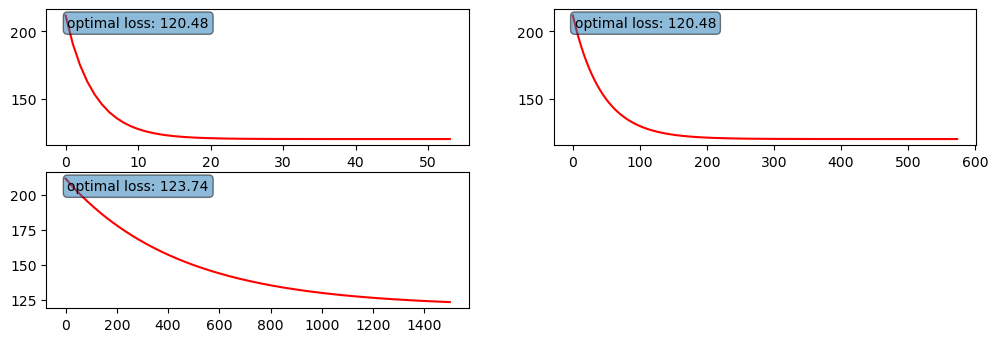

In [131]:
# optimal_loss = 10000
# optimal_I = 0
def multivariate_regularized_ols(xvalue_matrix, yvalues, R=0.01, MaxIterations=1500,lmbda=0,i=1):
    start_time = time.time()
    # Your code here
    # initialization
    epsilon = 0.00001
    n, k = xvalue_matrix.shape  #k is the num of features
    X = np.hstack((np.ones((n,1)), xvalue_matrix))
    y = yvalues.reshape(-1,1)
    beta = np.zeros((k+1,1))
    it = []
    loss =[]
    losss=0
    # gradient descending
    for iteration in range(MaxIterations):
        #predictions
        predictions = np.dot(X,beta)
        error = y-predictions

        gradient = (-np.dot(X.T, error))/n+lmbda* beta/n    #(np.r_[np.zeros((1,1)), beta[1:]]**2)/n
        losss = np.linalg.norm(error)
        loss.append(losss)
        it.append(iteration)
        #update
        beta = beta - R*gradient

        #check for convergence
        if np.linalg.norm(gradient) < epsilon:
            break
    # print("gradient:",gradient)
    #subplotting the loss
    plt.subplot(3,2,i)
    plt.plot(it, loss, color='red', label='loss')
    plt.annotate(f'optimal loss: {losss:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', 
                    verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))
    # if(optimal_loss>losss):
    #     optimal_loss = losss
    #     optimal_I = i
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    #outcome
    alpha = beta[0]
    beta_array = beta[1:]
    return alpha, beta_array

learning_rate = [0.1, 0.01, 0.001]
#perform gradient descending
results = []
params =[]
plt.figure(figsize=(12,6))
i=1
xx=0
for R in learning_rate:
    alpha, beta = multivariate_regularized_ols(X_train_st,y_train, R=R,lmbda=10000,i=i)
    i+=1
    if R==1:
        xx = alpha
    results.append({'Alpha': alpha, 'Beta': beta})
    params.append(list(beta))

final_results = pd.DataFrame(results)
# print(final_results)

#calculate RMSE
#using the optimal_params
optimal_params = params[1]
# print(optimal_params)
train_pred = np.dot(X_train_st,optimal_params)+xx
test_pred = np.dot(X_test_st,optimal_params)+xx
# print(train_pred)
# print(X_train_st)
# train_pred = train_pred.flatten()
# test_pred = test_pred.flatten()
train_rmse = compute_rmse(train_pred,X_train_st)
test_rmse = compute_rmse(test_pred,X_test_st)
print("train_rmse:",train_rmse)
print("test_rmse:",test_rmse)

*Discuss your results here*  
train_rmse: 4.060816691320754
test_rmse: 4.00497638364060 21

### 4.4: Cross-validate lambda

This is where it all comes together! Use k-fold cross-validation to select the optimal value of lambda in a regression using all the polynomial features. In other words, define a set of different values of lambda. Then, using the 80% of your data that you set aside for training, iterate through the values of lambda one at a time. For each value of lambda, use k-fold cross-validation to compute the average cross-validated RMSE for that lambda value, computed as the average across the held-out folds. You should also record the average cross-validated train RMSE, computed as the average across the folds used for training. Create a scatter plot that shows RMSE as a function of lambda. The scatter plot should have two lines: a gold line showing the cross-validated RMSE, and a blue line showing the cross-validated train RMSE.  At this point, you should not have touched your held-out 20% of "true" test data.

What value of lambda minimizes your cross-validated RMSE? Fix that value of lambda, and train a new model using all of your training data with that value of lambda (i.e., use the entire 80% of the data that you set aside in 4.1). Calculate the RMSE for this model on the 20% of "true" test data. How does your test RMSE compare to the RMSE from 3.2, 4.2, 4.3 and to the RMSE from nearest neighbors? What do you make of these results? 

Go brag to your friends about how you just implemented cross-validated ridge-regularized multivariate regression using gradient descent optimization, from scratch!

19
Time taken: 0.27 seconds
Time taken: 0.28 seconds
Time taken: 0.23 seconds
Time taken: 0.24 seconds
Time taken: 0.23 seconds


<Figure size 1200x600 with 0 Axes>

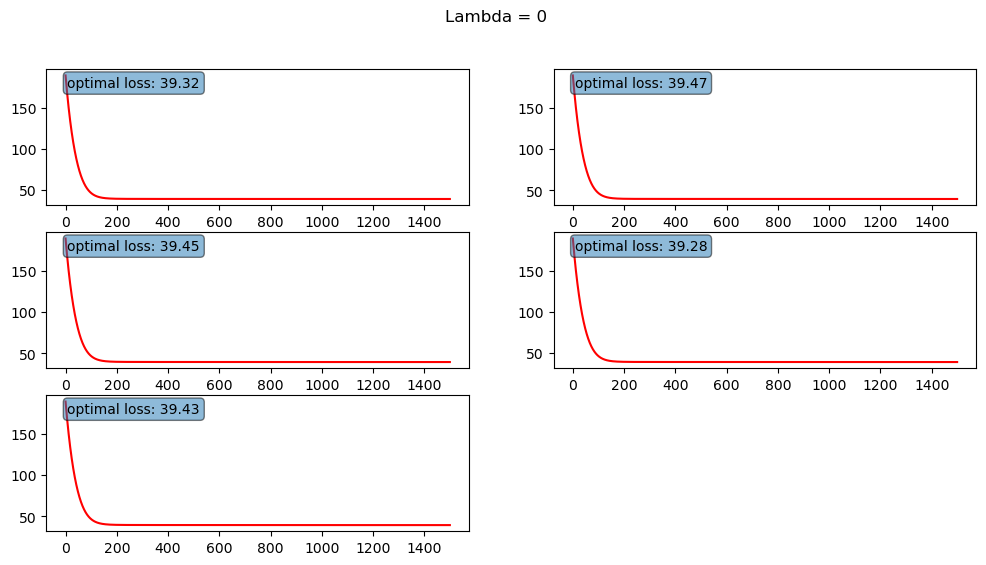

Time taken: 0.23 seconds
Time taken: 0.22 seconds
Time taken: 0.20 seconds
Time taken: 0.22 seconds
Time taken: 0.24 seconds


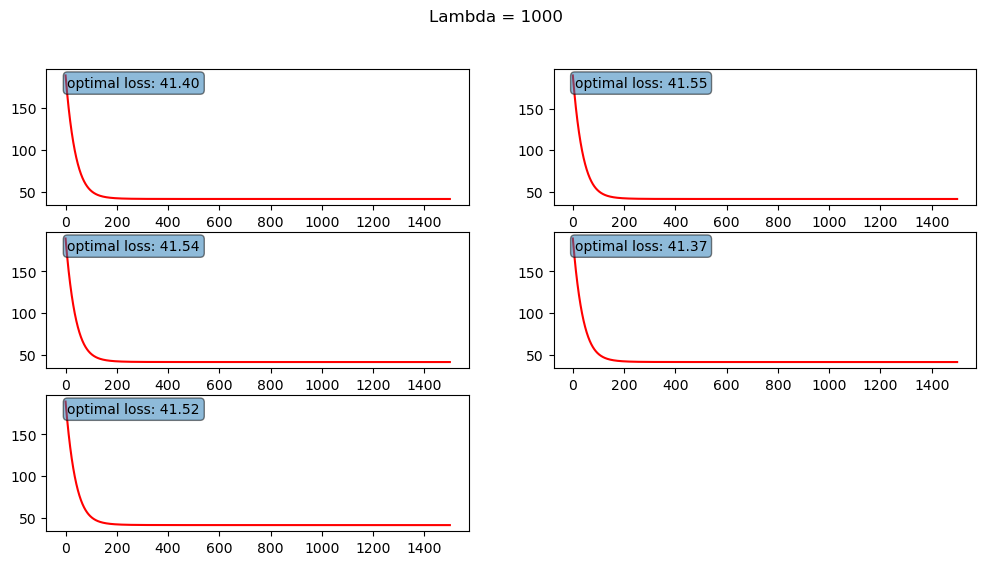

Time taken: 0.23 seconds
Time taken: 0.22 seconds
Time taken: 0.21 seconds
Time taken: 0.20 seconds
Time taken: 0.26 seconds


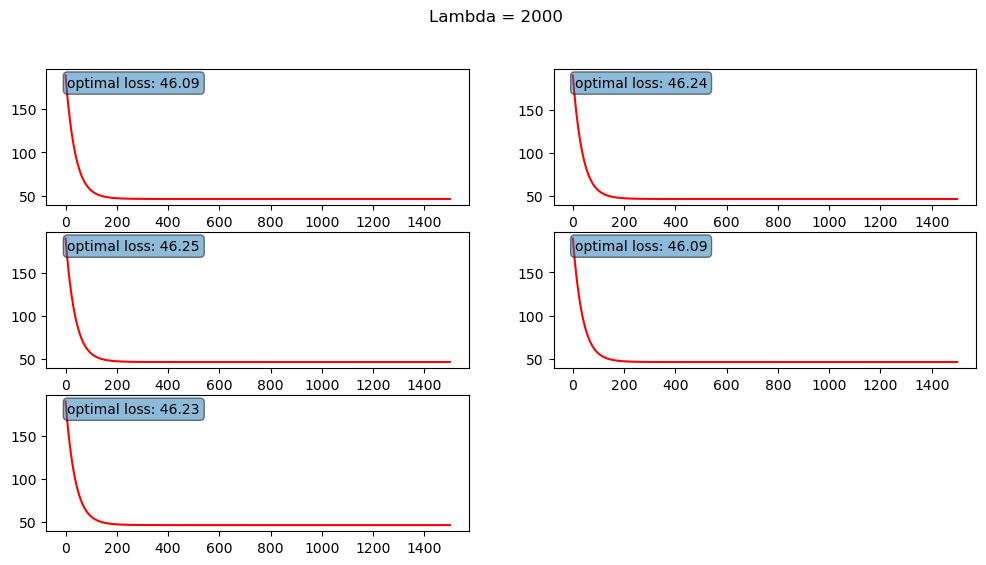

Time taken: 0.24 seconds
Time taken: 0.21 seconds
Time taken: 0.25 seconds
Time taken: 0.28 seconds
Time taken: 0.20 seconds


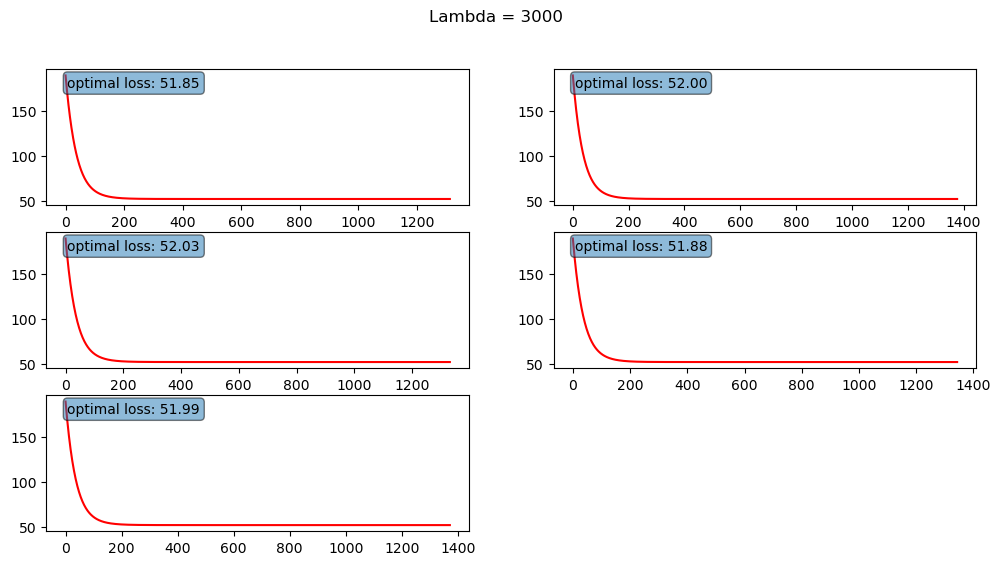

Time taken: 0.16 seconds
Time taken: 0.17 seconds
Time taken: 0.16 seconds
Time taken: 0.17 seconds
Time taken: 0.16 seconds


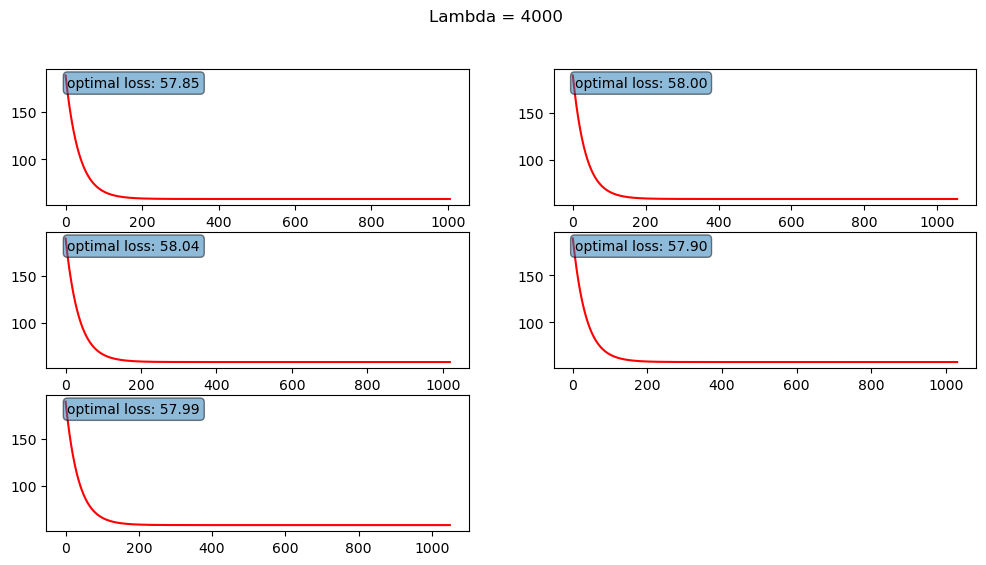

Time taken: 0.20 seconds
Time taken: 0.14 seconds
Time taken: 0.13 seconds
Time taken: 0.13 seconds
Time taken: 0.13 seconds


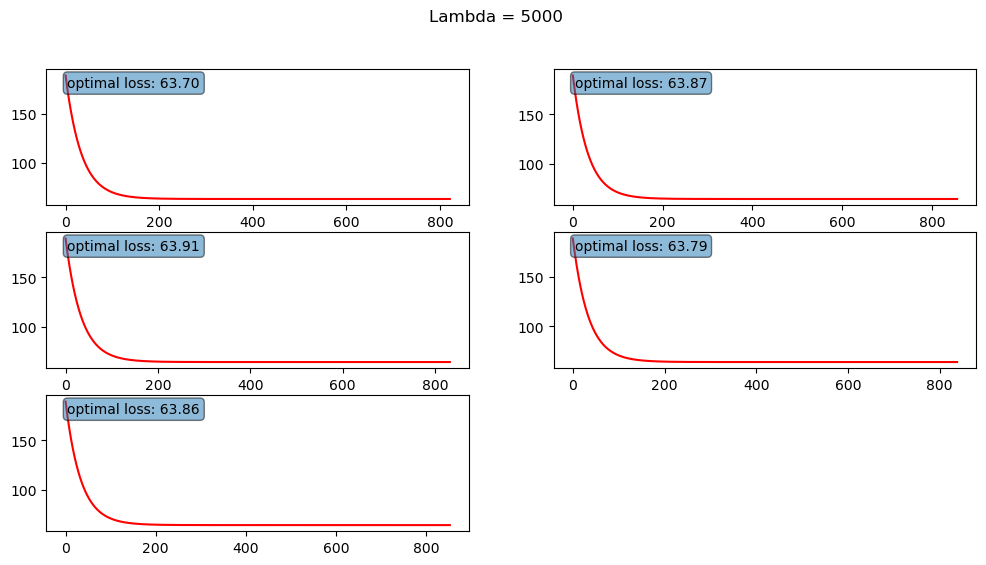

Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.12 seconds
Time taken: 0.13 seconds
Time taken: 0.12 seconds


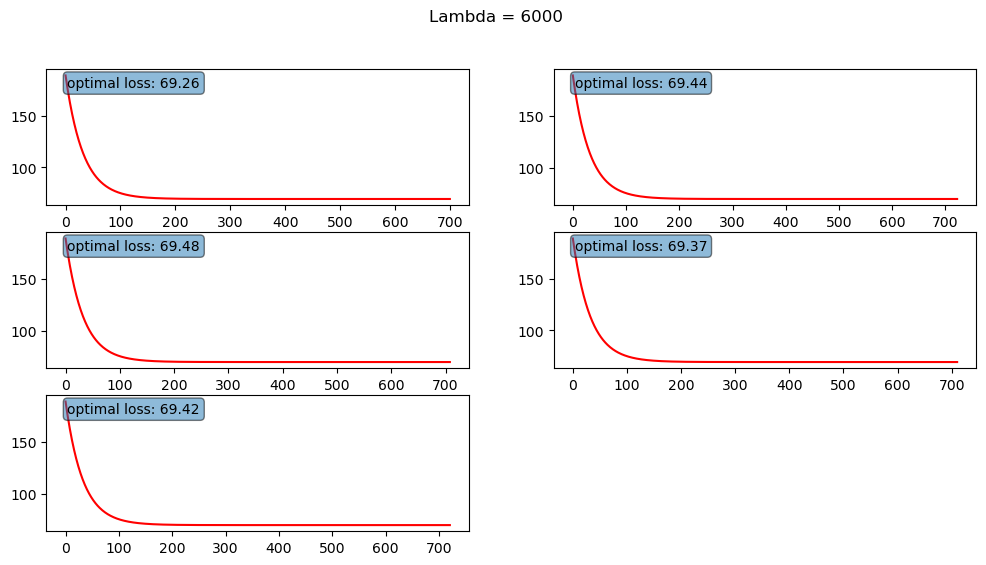

Time taken: 0.12 seconds
Time taken: 0.11 seconds
Time taken: 0.09 seconds
Time taken: 0.13 seconds
Time taken: 0.10 seconds


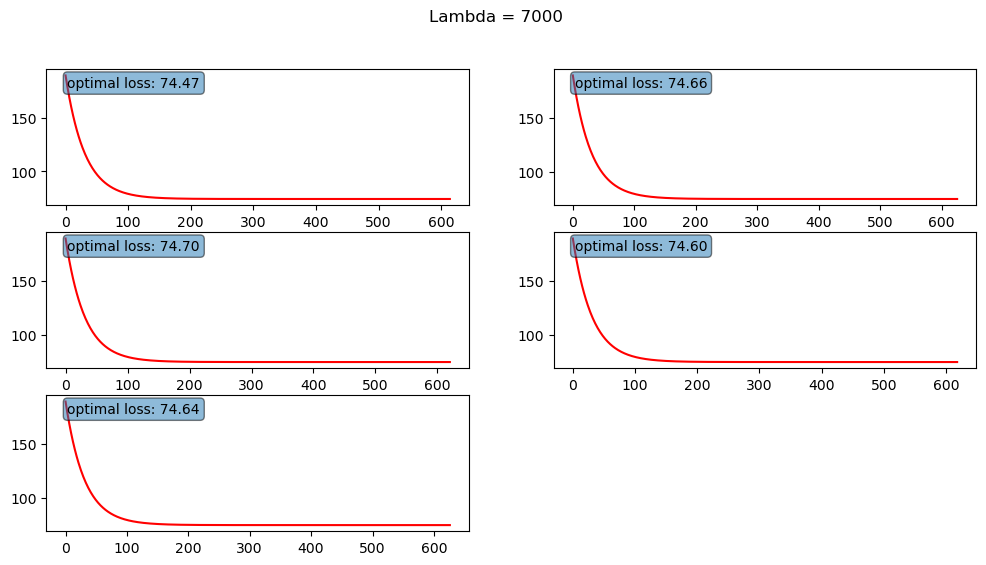

Time taken: 0.10 seconds
Time taken: 0.09 seconds
Time taken: 0.09 seconds
Time taken: 0.09 seconds
Time taken: 0.09 seconds


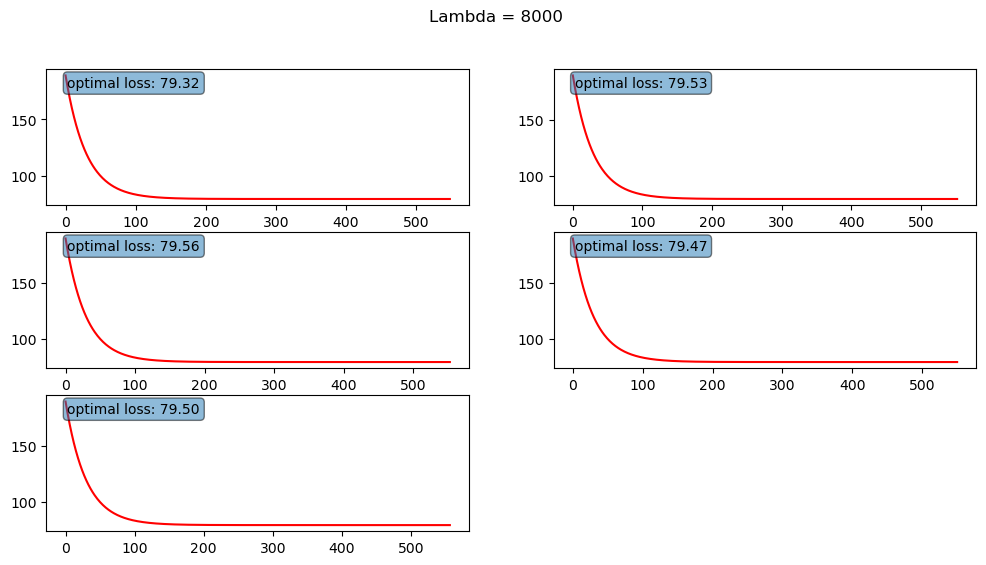

Time taken: 0.12 seconds
Time taken: 0.11 seconds
Time taken: 0.11 seconds
Time taken: 0.10 seconds
Time taken: 0.10 seconds


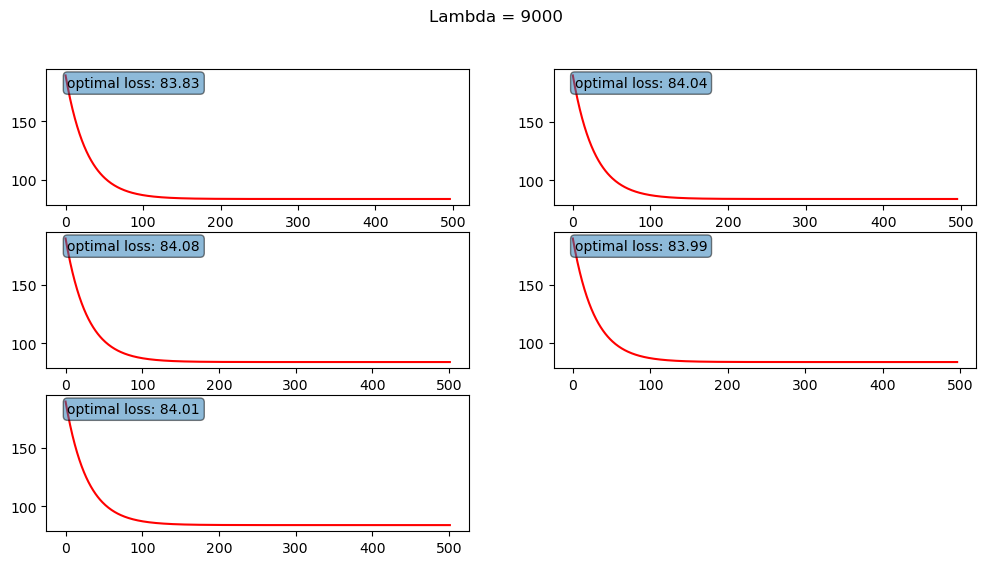

Time taken: 0.10 seconds
Time taken: 0.08 seconds
Time taken: 0.08 seconds
Time taken: 0.09 seconds
Time taken: 0.10 seconds


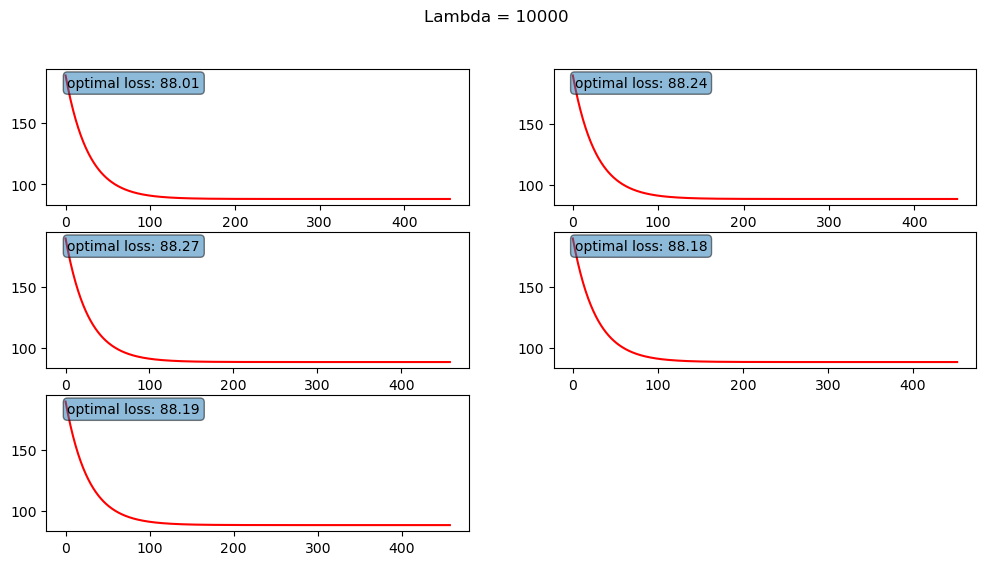

Time taken: 0.08 seconds
Time taken: 0.08 seconds
Time taken: 0.07 seconds
Time taken: 0.08 seconds
Time taken: 0.07 seconds


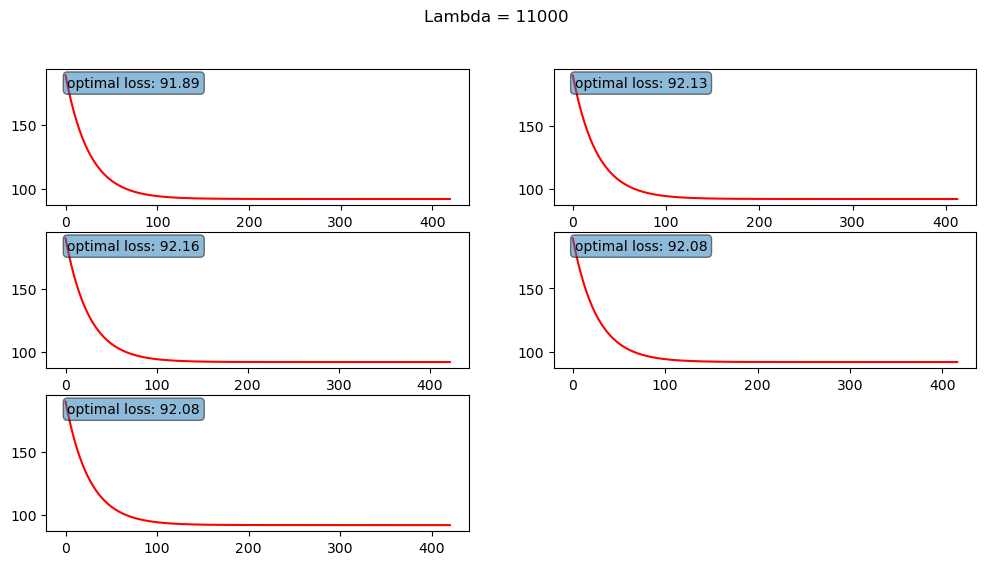

Time taken: 0.10 seconds
Time taken: 0.09 seconds
Time taken: 0.09 seconds
Time taken: 0.10 seconds
Time taken: 0.07 seconds


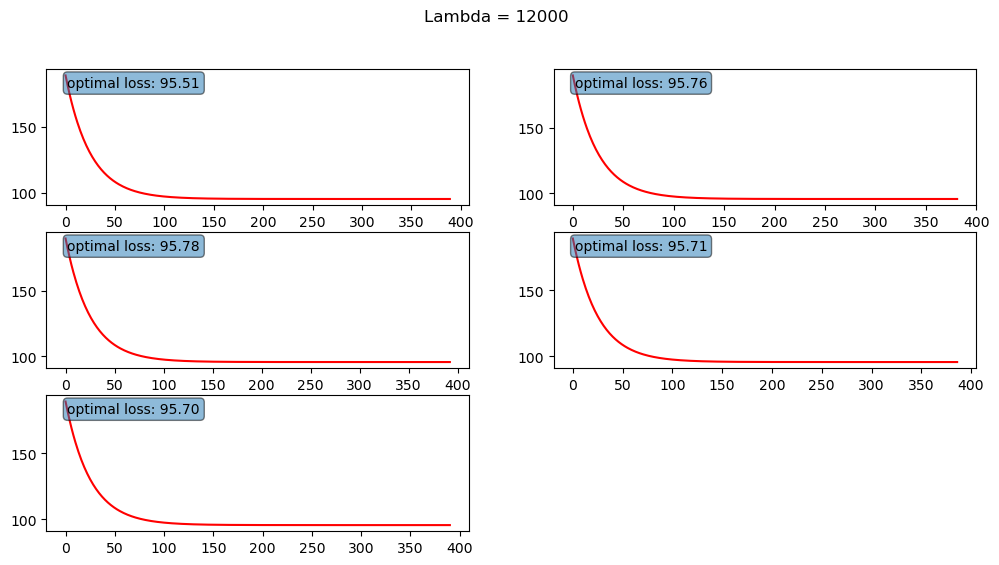

Time taken: 0.25 seconds
Time taken: 0.07 seconds
Time taken: 0.07 seconds
Time taken: 0.08 seconds
Time taken: 0.08 seconds


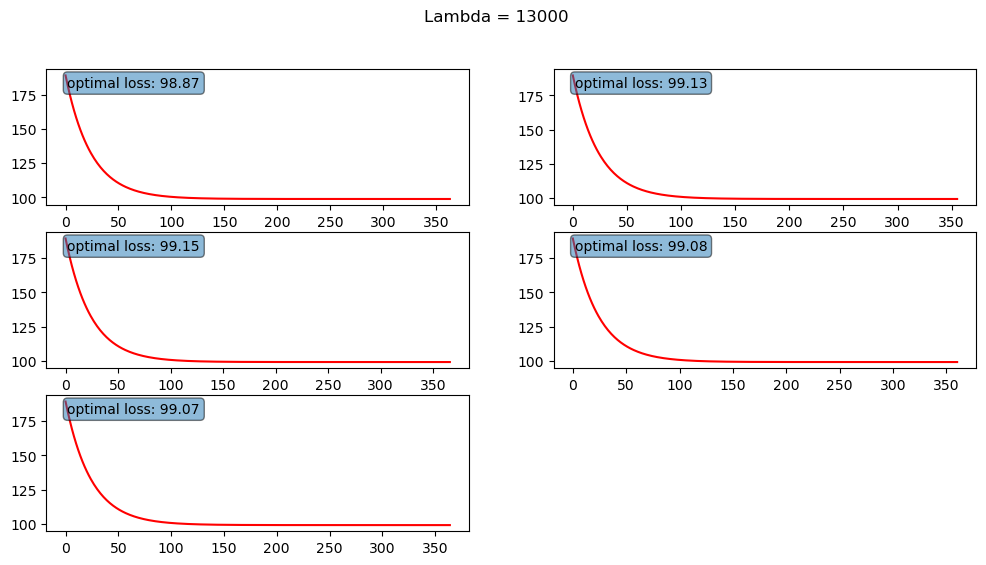

Time taken: 0.08 seconds
Time taken: 0.06 seconds
Time taken: 0.07 seconds
Time taken: 0.08 seconds
Time taken: 0.11 seconds


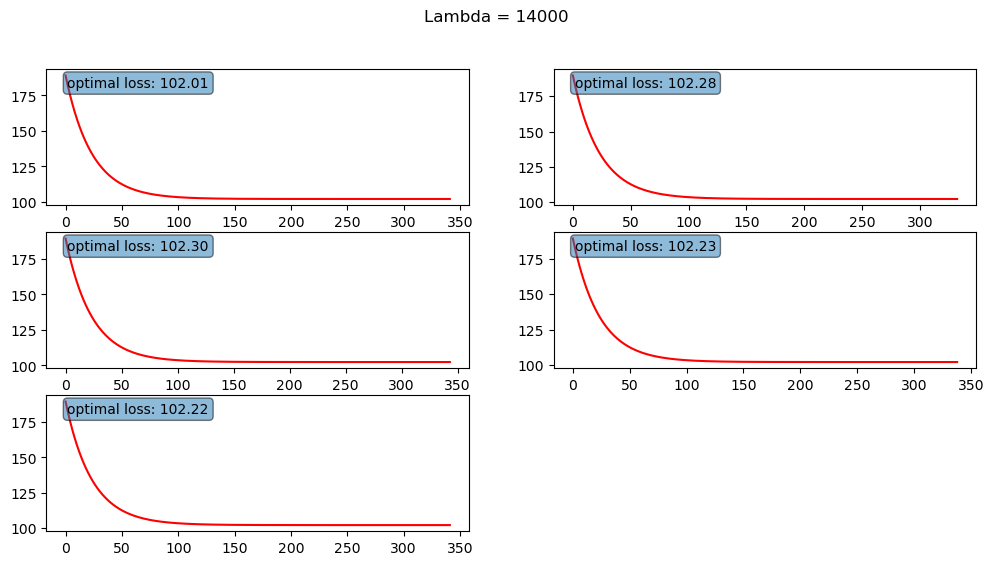

Time taken: 0.08 seconds
Time taken: 0.06 seconds
Time taken: 0.07 seconds
Time taken: 0.06 seconds
Time taken: 0.07 seconds


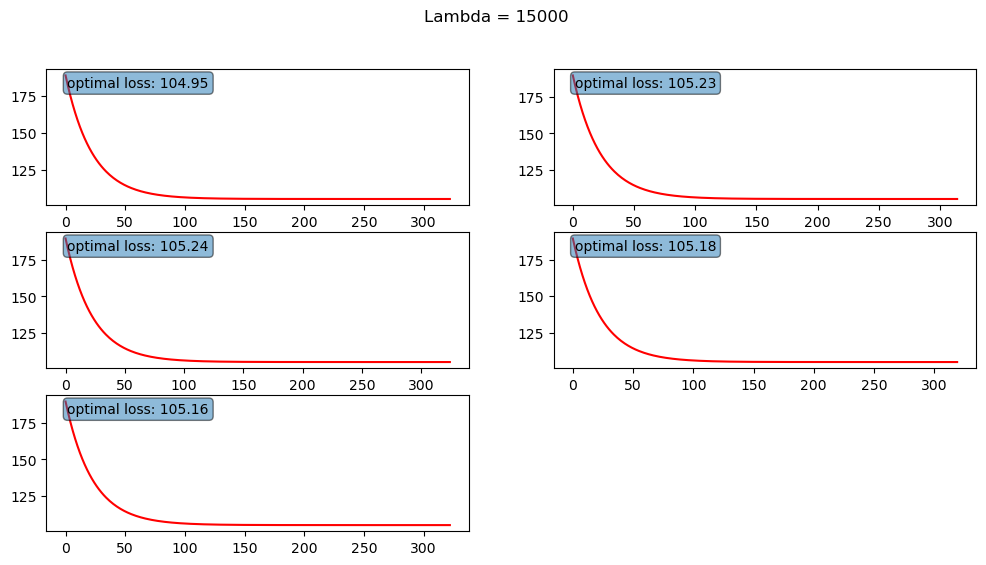

Time taken: 0.09 seconds
Time taken: 0.06 seconds
Time taken: 0.06 seconds
Time taken: 0.06 seconds
Time taken: 0.06 seconds


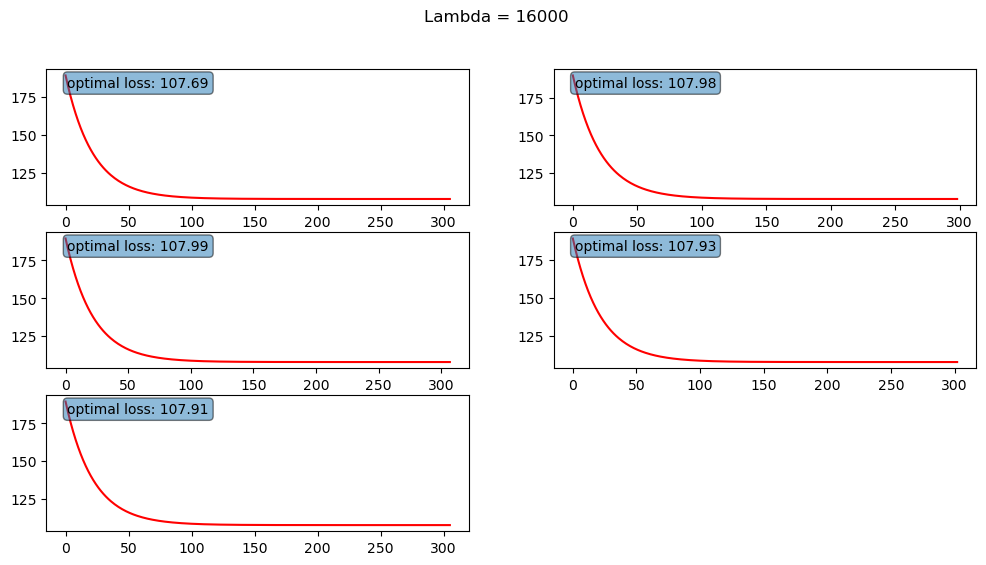

Time taken: 0.08 seconds
Time taken: 0.07 seconds
Time taken: 0.06 seconds
Time taken: 0.05 seconds
Time taken: 0.06 seconds


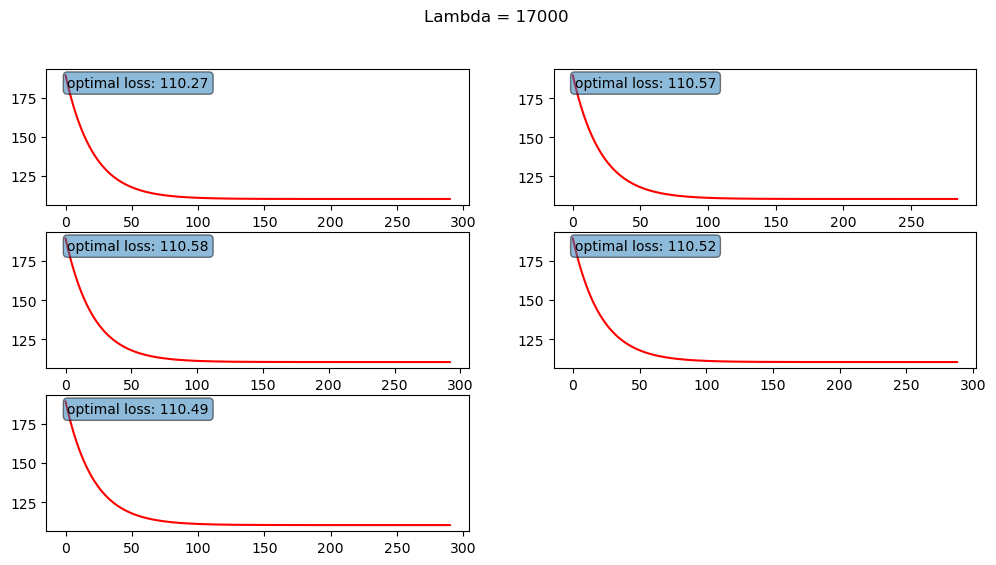

Time taken: 0.06 seconds
Time taken: 0.06 seconds
Time taken: 0.08 seconds
Time taken: 0.08 seconds
Time taken: 0.07 seconds


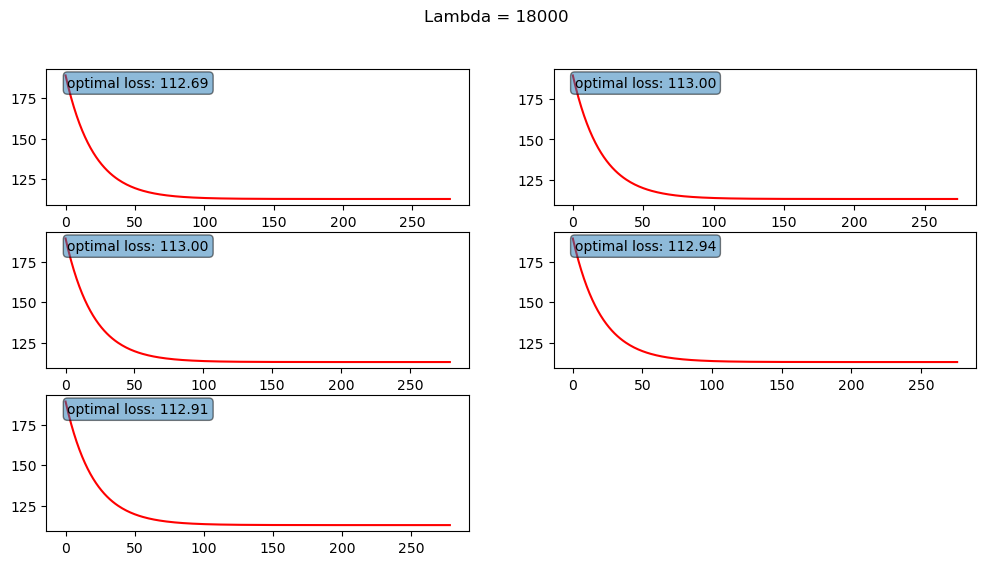

Time taken: 0.10 seconds
Time taken: 0.06 seconds
Time taken: 0.05 seconds
Time taken: 0.05 seconds
Time taken: 0.07 seconds


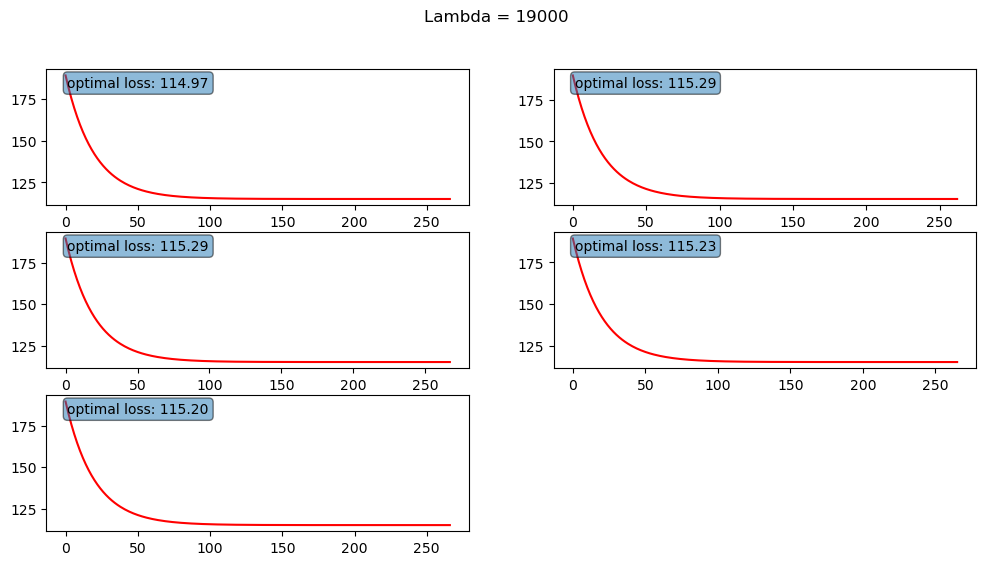

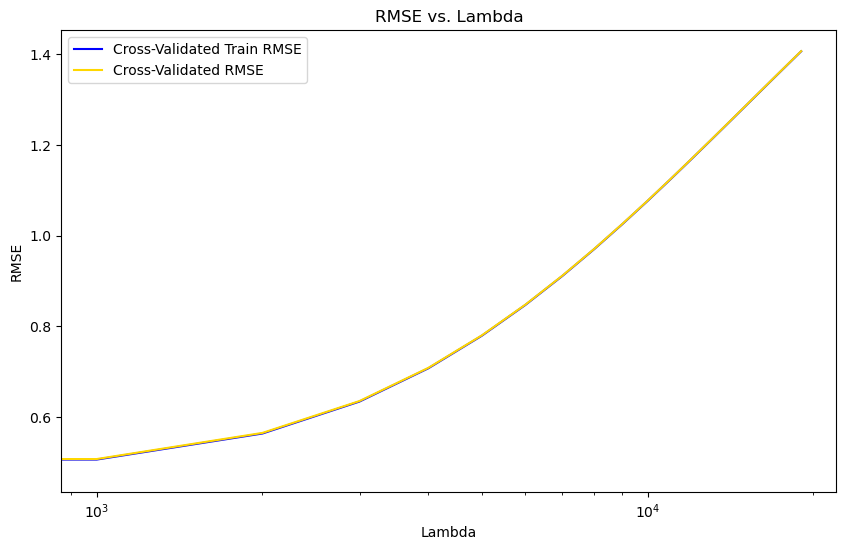

the optimal lambda is: 0


In [118]:
# Your code here
# step2: split the data into an 80%traing set
X_train, X_test, y_train2, y_test = train_test_split(poly_features, cal_df['MedHouseVal'], test_size=0.2, random_state=42)

y_train2 = y_train2.values
y_test = y_test.values
print(X_train.shape[1])
# standardization
X_train_st = standardize(X_train,X_train)
X_test_st = standardize(X_test,X_test)

#KFold
kf = KFold(n_splits = 5, shuffle=True, random_state=42)

plt.figure(figsize=(12,6))
coeffs = []
avg_rmse_train = []
avg_rmse_val = []

#define the optimal lambda
optimal_lambda = 0
#lambda list
# lambda_list = [500,1000, 5000, 10000, 20000]
lambda_list = range(0,20000,1000)
for lmbda in lambda_list:
    rmse_train, rmse_val = [], []
    plt.figure(figsize=(12,6))
    for i, (train_i, test_i) in enumerate(kf.split(X_train_st),start=1):
        X_train, X_val = X_train_st[train_i], X_train_st[test_i]
        y_train, y_val = y_train2[train_i], y_train2[test_i]
        
        # add intercept term
        intercept = np.ones((X_train.shape[0],1))
        intercept2 = np.ones((X_val.shape[0],1))
        X_train_i = np.hstack([intercept, X_train])
        X_val_i = np.hstack([intercept2,X_val])
        # model fitting
        alpha,beta = multivariate_regularized_ols(X_train_i, y_train, R=0.01, lmbda=lmbda, i=i)
        # print(beta)
        # prediction
        y_train_pred = X_train_i @beta+alpha  #matrix Multiplication
        y_val_pred = X_val_i @beta+alpha
        y_train_pred = y_train_pred.flatten()
        y_val_pred =y_val_pred.flatten()
        # calculate and store the rmse
        rmse_train.append(compute_rmse(y_train,y_train_pred))
        rmse_val.append(compute_rmse(y_val,y_val_pred))

        # save the coeffs
        coeffs.append(beta.flatten())

    avg_rmse_train.append(np.mean(rmse_train))
    avg_rmse_val.append(np.mean(rmse_val))
    plt.suptitle(f'Lambda = {lmbda}')
    plt.show()
# print(coeffs)
# coeffs_df = pd.DataFrame(coeffs, columns=['Intercept', 'Beta_MedInc', 'Beta_AveRooms', 'Beta_HouseAge'])
# print(coeffs_df)
# print("RMSE SCORES:",rmse_scores)
index_of_min = np.argmin(avg_rmse_val)
optimal_lambda = lambda_list[index_of_min]
plt.figure(figsize=(10, 6))
plt.plot(lambda_list, avg_rmse_train, label='Cross-Validated Train RMSE', color='blue')
plt.plot(lambda_list, avg_rmse_val, label='Cross-Validated RMSE', color='gold')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('RMSE')
plt.title('RMSE vs. Lambda')
plt.legend()
plt.show()

print("the optimal lambda is:", optimal_lambda)

19
Time taken: 0.23 seconds
the optimal test rmse is:  0.49463558098887955


C:\Users\Skylar_xty\AppData\Local\Temp\ipykernel_31680\369328708.py:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i)


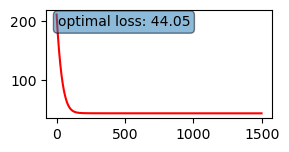

In [119]:
# fix the best value of lambda and train a new model
X_train, X_test, y_train, y_test = train_test_split(poly_features, cal_df['MedHouseVal'], test_size=0.2, random_state=42)

y_train = y_train.values
y_test = y_test.values
print(X_train.shape[1])
# standardization
X_train_st = standardize(X_train,X_train)
X_test_st = standardize(X_test,X_test)

plt.plot(figsize=(12,6))

# add intercept term
intercept = np.ones((X_train_st.shape[0],1))
intercept2 = np.ones((X_test_st.shape[0],1))
X_train_i = np.hstack([intercept, X_train_st])
X_test_i = np.hstack([intercept2,X_test_st])
# model fitting
alpha,beta = multivariate_regularized_ols(X_train_i, y_train, R=0.01, lmbda=optimal_lambda, i=i)
# prediction
# y_train_pred = X_train_i @beta  #matrix Multiplication
y_test_pred = X_test_i @beta+alpha
y_test_pred = y_test_pred.flatten()
rmse_on_test = compute_rmse(y_test_pred,y_test)
print("the optimal test rmse is: ", rmse_on_test)


*Discuss your results here*  
* The outcome suggests that it will be better to set the lambda to 0 with the optimal test rmse $0.49463558098887955$. Compared to the rmse in the above answer, it suggested that in this circumstance, we'd better not use Ridge regularization. But compared to the nearest neighbor algorithm, it got better outcome since it used all polynomial features, which may make a good effect.

### 4.5: Compare your results to sklearn ridge [extra-credit]

Repeat your analysis in 4.4, but this time use the sklearn implementation of ridge regression (sklearn.linearmodel.Ridge). Are the results similar? How would you explain the differences, if any?

19


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

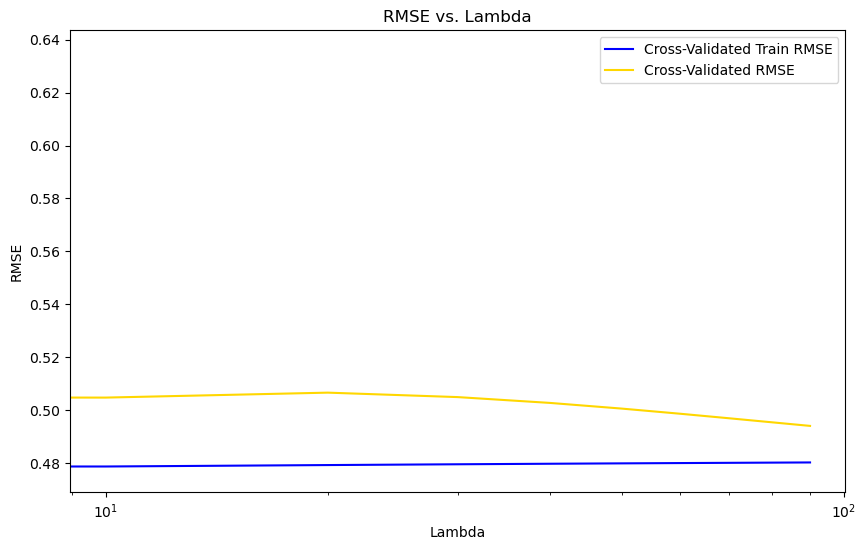

the optimal lambda is: 90
the least rmse on val is: 0.49403679605261674


In [121]:
# Your code here
# step2: split the data into an 80%training set
X_train, X_test, y_train2, y_test = train_test_split(poly_features, cal_df['MedHouseVal'], test_size=0.2, random_state=42)

y_train2 = y_train2.values
y_test = y_test.values
print(X_train.shape[1])
# standardization
X_train_st = standardize(X_train,X_train)
X_test_st = standardize(X_test,X_test)

#KFold
kf = KFold(n_splits = 5, shuffle=True, random_state=42)

plt.figure(figsize=(12,6))
coeffs = []
avg_rmse_train = []
avg_rmse_val = []

#define the optimal lambda
optimal_lambda = 0
#lambda list
# lambda_list = [500,1000, 5000, 10000, 20000]
lambda_list = range(0,100,10)
for lmbda in lambda_list:
    rmse_train, rmse_val = [], []
    plt.figure(figsize=(12,6))
    for i, (train_i, test_i) in enumerate(kf.split(X_train_st),start=1):
        X_train, X_val = X_train_st[train_i], X_train_st[test_i]
        y_train, y_val = y_train2[train_i], y_train2[test_i]
        
        # add intercept term
        # intercept = np.ones((X_train.shape[0],1))
        # intercept2 = np.ones((X_val.shape[0],1))
        # X_train_i = np.hstack([intercept, X_train])
        # X_val_i = np.hstack([intercept2,X_val])
        # model fitting
        # alpha,beta = multivariate_regularized_ols(X_train_i, y_train, R=0.01, lmbda=lmbda, i=i)
        model = Ridge(alpha = lmbda)
        model.fit(X_train,y_train)
        # prediction
        # y_train_pred = X_train_i @beta  #matrix Multiplication
        # y_val_pred = X_val_i @beta
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        # calculate and store the rmse
        rmse_train.append(compute_rmse(y_train,y_train_pred))
        rmse_val.append(compute_rmse(y_val,y_val_pred))

        # save the coeffs
        coeffs.append(beta.flatten())

    avg_rmse_train.append(np.mean(rmse_train))
    avg_rmse_val.append(np.mean(rmse_val))
    plt.suptitle(f'Lambda = {lmbda}')
    plt.show()

index_of_min = np.argmin(avg_rmse_val)
optimal_lambda = lambda_list[index_of_min]
plt.figure(figsize=(10, 6))
plt.plot(lambda_list, avg_rmse_train, label='Cross-Validated Train RMSE', color='blue')
plt.plot(lambda_list, avg_rmse_val, label='Cross-Validated RMSE', color='gold')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('RMSE')
plt.title('RMSE vs. Lambda')
plt.legend()
plt.show()

print("the optimal lambda is:", optimal_lambda)
print("the least rmse on val is:", np.min(avg_rmse_val))

*Discuss your results here*  
* the Ridge package in sklearn really achieved a good result with the optimal RMSE (0.49403679605261674), which is far better than any other results. And the optimal lambda here is 90.

### 4.6: AdaGrad [extra-credit]

AdaGrad is a method to implement gradient descent with different learning rates for each feature. Adaptive algorithms like this one are being extensively used especially in neural network training. Implement AdaGrad on 2.3 using `MedInc`, `HouseAge` and `AveRooms` as independent variables. Standardize these variables before inputting them to the gradient descent algorithm. Tune the algorithm until you estimate the regression coefficients within a tolerance of 1e-1. Use mini-batch gradient descent in this implementation. In summary for each parameter (in our case one intercept and three slopes) the update step of the gradient (in this example $\beta_j$) at iteration $k$ of the GD algorithm becomes:

$$\beta_j=\beta_j -\frac{R}{\sqrt{G^{(k)}_j}}\frac{\partial J(\alpha,\beta_1,\ldots)}{\partial \beta_j}$$ where
$G^{(k)}_j=\sum_{i=1}^{k} (\frac{\partial J^{(i)}(\alpha,\beta_1,\ldots)}{\partial \beta_j})^2$ and $R$ is your learning rate. The notation $\frac{\partial J^{(i)}(\alpha,\beta_1,\ldots)}{\partial \beta_j}$ corresponds to the value of the gradient at iteration $(i)$. Essentially we are "storing" information about previous iteration gradients. Doing that we effectively decrease the learning rate slower when a feature $x_i$ is sparse (i.e. has many zero values which would lead to zero gradients). Although this method is not necessary for our regression problem, it is good to be familiar with these methods as they are widely used in neural network training.  

In [122]:
# Your code here
# adagrad is a optimization method to adjust the learning rate.
def compute_gradient(X, y, beta):
    predictions = X.dot(beta)
    errors = predictions - y
    gradient = 2 * X.T.dot(errors) / len(y)
    return gradient
def adagrad(X, y, learning_rate=0.01, batch_size=32, max_iter=1000, tolerance=1e-1, epsilon=1e-8):
    n,k=X.shape  #k:# of features, 
    beta = np.zeros(k)
    G = np.zeros(k)
    for i in range(max_iter):
        for batch in range(0, n, batch_size):
            X_batch = X[batch:batch+batch_size]
            y_batch = y[batch:batch+batch_size]
            gradient = compute_gradient(X_batch, y_batch, beta)
            G += gradient **2
            beta_adjusted_lr = learning_rate / (np.sqrt(G + epsilon))
            beta -= beta_adjusted_lr * gradient

        if np.linalg.norm(gradient) < tolerance:
            break
    return beta

# step2: split the data into an 80%training set
# X_train, X_test, y_train2, y_test = train_test_split(poly_features, cal_df['MedHouseVal'], test_size=0.2, random_state=42)

# y_train2 = y_train2.values
# y_test = y_test.values
# print(X_train.shape[1])
# # standardization
# X_train_st = standardize(X_train,X_train)
# X_test_st = standardize(X_test,X_test)

features = cal_df[['MedInc','HouseAge', 'AveRooms']].values
target = cal_df['MedHouseVal'].values
#standize
features = standardize(ref=features,tar=features)
target = standardize(ref=target, tar=target)
beta = adagrad(features, target)

# Compute RMSE for training and testing sets 
train_predictions = features.dot(beta)


train_rmse = compute_rmse(train_predictions, target)
# test_rmse = compute_rmse(test_predictions, target)
# train_rmse = np.sqrt(np.mean((y_train2 - train_predictions) ** 2))
# test_rmse = np.sqrt(np.mean((y_test - test_predictions) ** 2))

print("Train RMSE:", train_rmse)
# print("Test RMSE:", test_rmse)

Train RMSE: 0.901067117361048


*Discuss your results here*  
* The RMSE here is 0.901067117361048, which is a great outcome similar to the result in Q3.2.